### calculate the leadtime-dependent climatological terciles, deciles and percentiles (0.02, then 0.05 to 0.95 with 0.05 step) from the individual GCMs' hindcast dataset (period 1993 - 2016) for countries 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os and standard libraries 
import os
import sys
from collections import OrderedDict
from itertools import product

### datetimes
from datetime import datetime, timedelta

### scipy
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import dask
from dask.diagnostics import ProgressBar
from tqdm import tqdm

### plotting
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns


In [3]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [4]:
sys.path.append('../../') 

In [5]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

### dictionnary holding quantile name and quantile values, they are passed as **lists** to avoid any numerical issues 

In [6]:
dict_quantiles = OrderedDict()
dict_quantiles['tercile'] = [0.3333, 0.6666]
dict_quantiles['quartile'] = [0.250, 0.500, 0.750]
dict_quantiles['decile'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dict_quantiles['percentile'] = [0.02, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95] 

### list of GCMs with complete hindcast period 

In [7]:
GCMs = ['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP', 'JMA']

### PARAMETERS FOR PAPERMILL 

In [8]:
provider = 'CDS'
varname = 'tprate'
period = 'seasonal'
GCM = 'ECMWF'
quantiles = 'tercile'
country = "Nauru"
admin = "Nauru"

In [9]:
# Parameters
country = "Marshall Islands"
admin = "Northern Marshall Islands"
GCM = "JMA"
quantiles = "quartile"


### path definitions follow

### figures 

In [10]:
fig_path = CWD.parents[1].joinpath("figures/ICU_validation/")

### outputs 

In [11]:
outputs_path = CWD.parents[1].joinpath("outputs/ICU_validation/admin")

In [12]:
outputs_path

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/ICU_validation/admin')

# where to find the GCM hindcast datasets 

In [13]:
gcm_path = pathlib.Path(f'/media/nicolasf/END19101/ICU/data/{provider}')

In [14]:
dpath = gcm_path.joinpath(GCM).joinpath(varname.upper())

In [15]:
print(dpath)

/media/nicolasf/END19101/ICU/data/CDS/JMA/TPRATE


#### where to save the climatologies 

In [16]:
clim_path = gcm_path.joinpath(f'CLIMATOLOGY/{GCM}')

In [17]:
clim_path

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/CLIMATOLOGY/JMA')

In [18]:
if not clim_path.exists(): 
    
    clim_path.mkdir(parents=True)

### get the list of files 

In [19]:
dpath

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/JMA/TPRATE')

In [20]:
lfiles = list(dpath.glob(f"ensemble_seas_forecasts_{varname}_from_*_{GCM}.netcdf"))

In [21]:
lfiles.sort()

## only keep the list of files to 2016

In [22]:
def get_date(l): 
    return int(l.name.split('_')[5])

In [23]:
lfiles = [x for x in lfiles if get_date(x) <= 2016]

In [24]:
dset = xr.open_mfdataset(lfiles, preprocess=C3S.preprocess_GCM, parallel=True, engine='netcdf4')

In [25]:
dset = dset.sortby('time')

In [26]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (time: 288, member: 10, step: 5, lat: 81, lon: 121)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9
  * step     (step) int64 1 2 3 4 5
  * lon      (lon) float64 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * lat      (lat) float64 -50.0 -49.0 -48.0 -47.0 -46.0 ... 27.0 28.0 29.0 30.0
Data variables:
    tprate   (time, step, member, lat, lon) float32 dask.array<chunksize=(1, 5, 10, 81, 121), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 20:13:48 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...>

### print the number of members in the ensemble for each time step 

In [27]:
# for t in range(len(dset.time)): 
    
#     s = dset.isel(time=t)
    
#     print(f"{pd.to_datetime(dset.isel(time=t)['time'].data):%Y-%m}:", len(s.dropna('member')['member']))

### selects the hindcast period 

In [28]:
dset = dset.sel(time=slice('1993', '2016'))

In [29]:
dset

,Array,Chunk
Bytes,538.39 MiB,1.87 MiB
Shape,"(288, 5, 10, 81, 121)","(1, 5, 10, 81, 121)"
Count,6110 Tasks,288 Chunks
Type,float32,numpy.ndarray


### convert to monthly rainfall accumulations (mm/month)

In [30]:
dset.tprate.attrs

{'units': 'm s**-1', 'long_name': 'Mean total precipitation rate'}

In [31]:
dset = C3S.convert_rainfall(dset, varin='tprate', varout='precip', leadvar='step', timevar='time', dropvar=True)


unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in var = precip


In [32]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (time: 288, member: 10, step: 5, lon: 121, lat: 81)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9
  * step     (step) int64 1 2 3 4 5
  * lon      (lon) float64 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * lat      (lat) float64 -50.0 -49.0 -48.0 -47.0 -46.0 ... 27.0 28.0 29.0 30.0
Data variables:
    precip   (time, step, member, lat, lon) float64 dask.array<chunksize=(1, 5, 10, 81, 121), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 20:13:48 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...>

In [33]:
dset.precip.attrs

{'units': 'mm/month'}

### make sure there are no negative values 

In [34]:
dset = dset.clip(min=0)

### if the period is set to `seasonal`, calculates the seasonal accumulations 

In [35]:
if period == 'seasonal': 
    
    dset = dset.rolling({'step':3}, min_periods=3).sum('step')
    
    dset = dset.sel({'step':slice(3, None)})

In [36]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (time: 288, member: 10, step: 3, lon: 121, lat: 81)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9
  * step     (step) int64 3 4 5
  * lon      (lon) float64 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * lat      (lat) float64 -50.0 -49.0 -48.0 -47.0 -46.0 ... 27.0 28.0 29.0 30.0
Data variables:
    precip   (time, step, member, lat, lon) float64 dask.array<chunksize=(1, 3, 10, 81, 121), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 20:13:48 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...>

In [37]:
steps = dset.step.data

In [38]:
steps

array([3, 4, 5])

### calculate percentiles over the dimensions member and time, will then be lead time dependent 

In [39]:
coastlines_dpath = pathlib.Path('/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/Admin_boundaries/Coastlines')

In [40]:
shapefile = gpd.read_file(coastlines_dpath.joinpath('ICU_admin_geometries0_360.shp'))

In [41]:
shapefile

,id,Country,Admin_boun,geometry
0,1,Northern Mariana Islands,Southern Islands,"MULTIPOLYGON (((145.135 14.139, 145.135 14.138..."
1,2,Northern Mariana Islands,Northern Islands,"MULTIPOLYGON (((146.058 16.013, 146.056 16.012..."
2,3,Guam,Guam,"MULTIPOLYGON (((144.658 13.240, 144.650 13.235..."
3,4,Palau,Babeldaob region,"MULTIPOLYGON (((134.124 6.922, 134.125 6.922, ..."
4,5,Palau,South-west Islands,"MULTIPOLYGON (((131.812 2.971, 131.811 2.974, ..."
...,...,...,...,...
68,24,Cook Islands,Northern Cook Islands,"MULTIPOLYGON (((196.885 -13.333, 196.884 -13.3..."
69,70,FSM,Kapingamarangi,"MULTIPOLYGON (((154.779 1.027, 154.781 1.028, ..."
70,71,Marshall Islands,Southern Marshall Islands,"MULTIPOLYGON (((168.765 4.604, 168.765 4.604, ..."
71,72,Marshall Islands,Central Marshall Islands,"MULTIPOLYGON (((168.769 7.281, 168.769 7.281, ..."


In [42]:
country_col = 'Country'
admin_col = 'Admin_boun'

In [43]:
shapefile.loc[:,f"{admin_col}"] = shapefile.loc[:,f"{admin_col}"].str.replace("'","")

### restrict to country 

In [44]:
sub = shapefile.query(f"Country == '{country}'")

In [45]:
shape = sub.query(f"{admin_col} == '{admin}'")

<AxesSubplot:>

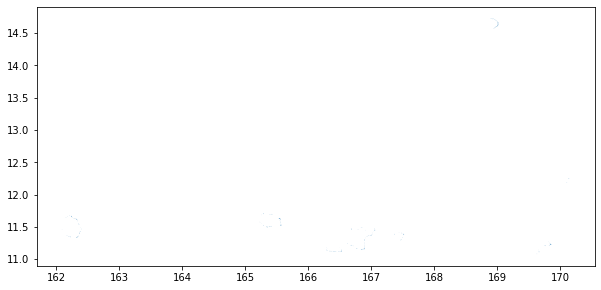

In [46]:
shape.plot(figsize=(10,10))

In [47]:
original_shape = shape.copy()

### for Island groups consituted of very small islands / atolls, we don't filter OUT the geometries, we actually buffer them  so that they can match the resolution of the GCM (once interpolated)

In [48]:
float(shape.to_crs('EPSG:3857').area / 10**6)

55.86984010307231

In [49]:
shape = shape.buffer(0.25)

In [50]:
# if float(shape.to_crs('EPSG:3857').area / 10**6) < 2000: 
#     shape = shape.buffer(0.25)
# else: 
#     shape = geo.filter_by_area(shape, min_area=500)

<AxesSubplot:>

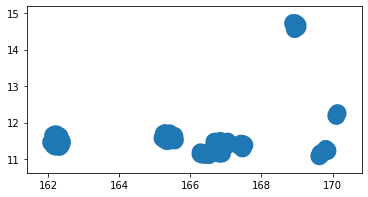

In [51]:
shape.plot()

### we use these filtered geometries to mask the GCM hindcast dataset

#### Note that the GCM dataset is first interpolated to 5X its original resolution 

In [52]:
dset

,Array,Chunk
Bytes,646.06 MiB,2.24 MiB
Shape,"(288, 3, 10, 81, 121)","(1, 3, 10, 81, 121)"
Count,15901 Tasks,288 Chunks
Type,float64,numpy.ndarray


In [53]:
shape

72    MULTIPOLYGON (((169.90138 12.33779, 169.90857 ...
dtype: geometry

In [54]:
dset

,Array,Chunk
Bytes,646.06 MiB,2.24 MiB
Shape,"(288, 3, 10, 81, 121)","(1, 3, 10, 81, 121)"
Count,15901 Tasks,288 Chunks
Type,float64,numpy.ndarray


In [55]:
dset, domain = geo.mask_dataset(dset, shape, coastline_buffer=15)

[########################################] | 100% Completed |  5.8s


In [56]:
dset

<xarray.Dataset>
Dimensions:  (time: 288, member: 10, step: 3, lat: 30, lon: 55)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9
  * step     (step) int64 3 4 5
  * lon      (lon) float64 161.0 161.2 161.4 161.6 ... 170.4 170.6 170.8 171.0
  * lat      (lat) float64 10.0 10.17 10.34 10.52 ... 14.48 14.66 14.83 15.0
Data variables:
    precip   (time, step, member, lat, lon) float64 nan nan nan ... nan nan nan
    mask     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 20:13:48 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

### number of grid points 

In [57]:
dset['mask'].attrs['cells']

171

### plots the shape(s) and the resulting land sea mask  

In [58]:
if GCM == 'ECMWF': 

    f, axes = plt.subplots(ncols=2, figsize=(10, 10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

    ax = axes[0]

    shape.plot(ax=ax, color='0.6', alpha=0.2, transform=ccrs.PlateCarree())

    shape.boundary.plot(ax=ax, color='coral', lw=0.7, transform=ccrs.PlateCarree())

    original_shape.boundary.plot(ax=ax, color='steelblue', lw=0.7, alpha=0.5, transform=ccrs.PlateCarree())

    ax.set_title(f"{country} {admin} coastlines and shape")

#     plot.make_gridlines(ax)

    ax = axes[1]

    dset['mask'].plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), alpha=0.5)

    original_shape.boundary.plot(ax=ax, color='k', lw=0.7, transform=ccrs.PlateCarree())

    ax.set_title(f"{country} {admin} mask")

#     plot.make_gridlines(ax)

    f.savefig(fig_path.joinpath(f'masks/{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}_shapes_and_mask.png'), dpi=200, bbox_inches='tight', facecolor='w')

### plots the precipitation field for one time step, leadtime and member 

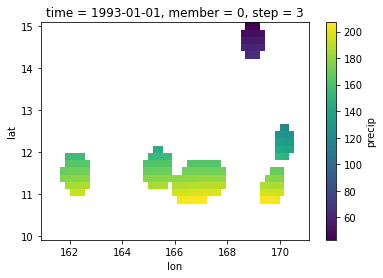

In [59]:
dset.isel(time=0, step=0, member=0)['precip'].plot()

### calculates the regional average (average over lats and lons)

In [60]:
dset_sub = dset.mean(['lat','lon'])

### and the calculates the climatological percentiles 

In [61]:
dset_sub

<xarray.Dataset>
Dimensions:  (time: 288, member: 10, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9
  * step     (step) int64 3 4 5
Data variables:
    precip   (time, step, member) float64 159.4 92.29 56.17 ... 160.7 228.2
    mask     float64 1.0

In [62]:
dset_sub

<xarray.Dataset>
Dimensions:  (time: 288, member: 10, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9
  * step     (step) int64 3 4 5
Data variables:
    precip   (time, step, member) float64 159.4 92.29 56.17 ... 160.7 228.2
    mask     float64 1.0

In [63]:
clim_p = dset_sub.groupby(dset_sub.time.dt.month).apply(C3S.calc_empirical_quantiles, \
                                                              **{'quantiles':dict_quantiles[quantiles], 'dims':('time','member')})

### plot the climatological quantiles as a function of leadtime ('step' dimension)

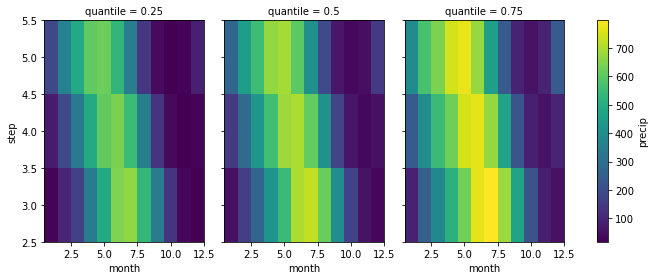

In [64]:
clim_p['precip'].plot(x='month', y = 'step', col='quantile', figsize=(10, 4))

In [65]:
# clim_p = dset_sub['precip'].groupby(dset_sub.time.dt.month).apply(C3S.calc_percentiles, **{'percentiles':dict_quantiles[quantiles]})

In [66]:
# clim_p.plot(x='month', y = 'step', col='quantile', figsize=(10, 4))

### need to save the climatologies 

In [67]:
outputs_path.joinpath("climatologies")

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/ICU_validation/admin/climatologies')

In [68]:
print(f"saving {quantiles} climatology for {varname} {period} {GCM} {utils.sanitize_name(country)} {utils.sanitize_name(admin)}")

saving quartile climatology for tprate seasonal JMA Marshall_Islands Northern_Marshall_Islands


In [69]:
clim_p.to_netcdf(outputs_path.joinpath("climatologies").joinpath(f"parametrized_{quantiles}_{varname}_{period}_{GCM}_{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}.nc"))

### digitize: each member is given a category depending on the percentile bins defined earlier 

In [70]:
np.unique(dset_sub.time.dt.month)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [71]:
dset_cat = []

for month in np.unique(dset_sub.time.dt.month): 
    
    x = dset_sub.sel(time=(dset_sub.time.dt.month == month))
    
    # drop the missing members 
    
    x = x.dropna('member')
    
    # digitize

    qc = C3S.get_GCM_category_digitize(x, clim_p.sel(month=month), varname='precip', dim='quantile')
    
    dset_cat.append(qc)

### concatenates over the time dimension and reorder 

In [72]:
dset_cat = xr.concat(dset_cat, dim='time')
dset_cat = dset_cat.sortby('time')

In [73]:
dset_cat

<xarray.Dataset>
Dimensions:  (time: 288, member: 10, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9
  * step     (step) int64 3 4 5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, step, member) int64 4 4 3 2 2 3 3 3 2 ... 4 4 3 2 2 3 2 3 3

### Now calculates the probabilities as the proportion of members falling into each category 

In [74]:
quantiles_category_percent = C3S.calculate_quantiles_probabilities(dset_cat, ncategories=4)

In [75]:
quantiles_category_percent

<xarray.Dataset>
Dimensions:   (quartile: 4, time: 288, step: 3)
Coordinates:
  * time      (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step      (step) int64 3 4 5
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * quartile  (quartile) int64 1 2 3 4
Data variables:
    precip    (quartile, time, step) float64 0.0 10.0 0.0 ... 50.0 30.0 30.0

### because of numerical approximations, sometimes the sum over the quantile dimension is not strictly equal to 100.

In [76]:
np.alltrue((quantiles_category_percent.sum(quantiles)['precip'] == 100.))

<xarray.DataArray 'precip' ()>
array(True)

### but it is close enough 

In [77]:
np.alltrue((quantiles_category_percent.sum(quantiles)['precip'] >= 99.9999))

<xarray.DataArray 'precip' ()>
array(True)

In [78]:
np.alltrue((quantiles_category_percent.sum(quantiles)['precip'] <= 100.0001))

<xarray.DataArray 'precip' ()>
array(True)

In [79]:
quantiles_category_percent

<xarray.Dataset>
Dimensions:   (quartile: 4, time: 288, step: 3)
Coordinates:
  * time      (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step      (step) int64 3 4 5
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * quartile  (quartile) int64 1 2 3 4
Data variables:
    precip    (quartile, time, step) float64 0.0 10.0 0.0 ... 50.0 30.0 30.0

### saves the percentiles in netcdf 

In [80]:
# quantiles_category_percent.to_netcdf(outputs_path.joinpath(f"{quantiles}_categories_probabilities_hindcast_{GCM}_{period}_{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}.nc"))

### takes the percentile probabilities then casts into a pandas dataframe 

#### these are the leadtimes, in months, should be [1,2,3,4,5] if monthly, [3,4,5] if seasonal 

In [81]:
quantiles_category_percent

<xarray.Dataset>
Dimensions:   (quartile: 4, time: 288, step: 3)
Coordinates:
  * time      (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step      (step) int64 3 4 5
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * quartile  (quartile) int64 1 2 3 4
Data variables:
    precip    (quartile, time, step) float64 0.0 10.0 0.0 ... 50.0 30.0 30.0

### transform the xarray dataset into a pandas dataframe with multiindex columns (product of leadtimes and quantiles)

In [82]:
df_quantile_probabilities = []

for step in steps: 
    
    df = quantiles_category_percent.sel(step=step)['precip'].to_pandas().T
    
    cols = pd.MultiIndex.from_product([[step], df.columns]) 

    df.columns = cols 
    
    df_quantile_probabilities.append(df)


In [83]:
df_quantile_probabilities = pd.concat(df_quantile_probabilities, axis=1) 

In [84]:
df_quantile_probabilities.head()

3                       4                       5              \
quartile       1     2     3     4     1     2     3     4     1     2     3   
time                                                                           
1993-01-01   0.0  40.0  40.0  20.0  10.0  20.0  20.0  50.0   0.0  30.0  20.0   
1993-02-01  30.0  40.0   0.0  30.0  10.0  40.0  20.0  30.0  20.0  20.0  40.0   
1993-03-01   0.0  40.0  40.0  20.0  10.0  20.0  40.0  30.0  10.0  10.0  30.0   
1993-04-01  50.0   0.0  40.0  10.0  50.0  10.0  20.0  20.0  40.0  20.0  30.0   
1993-05-01  70.0  30.0   0.0   0.0  80.0  20.0   0.0   0.0  40.0  30.0  30.0   

                  
quartile       4  
time              
1993-01-01  50.0  
1993-02-01  20.0  
1993-03-01  50.0  
1993-04-01  10.0  
1993-05-01   0.0

### saves to disk 

In [85]:
outputs_path

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/ICU_validation/admin')

In [86]:
df_quantile_probabilities.to_csv(outputs_path.joinpath(f"{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}_{period}_{GCM}_{quantiles}_probs.csv"))

### Now we are going to read the ERA5 reanalysis precipitation data for the validation of the regional aggregates 

In [87]:
from ICU_Water_Watch import verification

In [88]:
use_verif = 'era'

In [89]:
dset_obs, dset_anomalies = verification.get_era5()

In [90]:
gcm_domain = domains.get_domain(dset)

In [91]:
gcm_domain

[161.0, 171.0, 10.0, 15.0]

In [92]:
dset_obs = dset_obs.sel(lon=slice(*gcm_domain[:2]), lat=slice(*gcm_domain[2:]))

In [93]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 288, lat: 6, lon: 11)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 15.0
  * lon      (lon) float64 161.0 162.0 163.0 164.0 ... 168.0 169.0 170.0 171.0
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1, 6, 11), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-21 14:37:06 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

### if seasonal, calculates the 3 months accumulations 

In [94]:
if period == 'seasonal': 
    
    dset_obs = dset_obs.rolling({"time":3}, min_periods=3, center=False).sum('time')
    
    dset_obs = dset_obs.isel(time=slice(2, None))

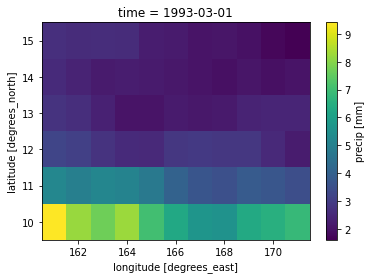

In [95]:
dset_obs['precip'][0,:,:].plot()

In [96]:
dset_obs = dset_obs.interp_like(dset[['lon','lat']])

In [97]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 286, lat: 30, lon: 55)
Coordinates:
  * time     (time) datetime64[ns] 1993-03-01 1993-04-01 ... 2016-12-01
  * lon      (lon) float64 161.0 161.2 161.4 161.6 ... 170.4 170.6 170.8 171.0
  * lat      (lat) float64 10.0 10.17 10.34 10.52 ... 14.48 14.66 14.83 15.0
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1, 30, 55), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-21 14:37:06 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

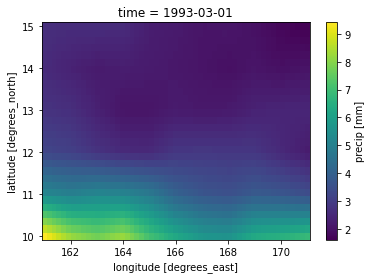

In [98]:
dset_obs['precip'][0,:,:].plot()

### insert the mask from the GCM dataset

In [99]:
dset_obs['mask'] = dset['mask']

### same grid and same mask as the GCM 

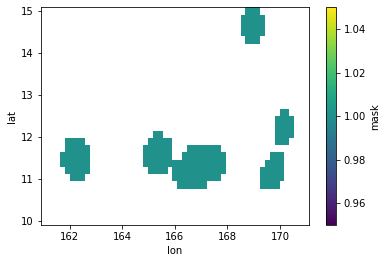

In [100]:
dset['mask'].plot()

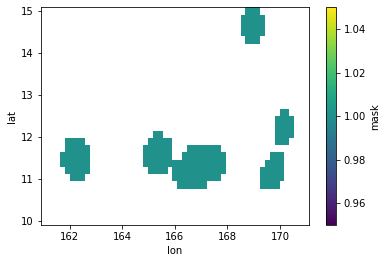

In [101]:
dset_obs['mask'].plot()

### apply the mask 

In [102]:
dset_obs['precip'] = dset_obs['precip'] * dset_obs['mask']

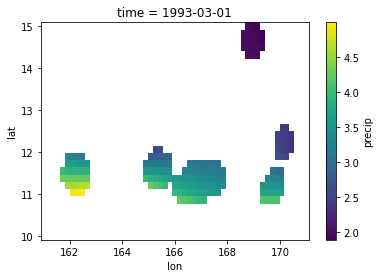

In [103]:
dset_obs.isel(time=0).squeeze()['precip'].plot()

### insert a dummy "member" dimension with one coordinate

In [104]:
dset_obs = dset_obs.expand_dims({'member':[1]})

### calculates the regional average 

In [105]:
dset_obs_sub = dset_obs[['precip']].mean(['lat','lon'])

In [106]:
dset_obs_sub

<xarray.Dataset>
Dimensions:  (member: 1, time: 286)
Coordinates:
  * member   (member) int64 1
  * time     (time) datetime64[ns] 1993-03-01 1993-04-01 ... 2016-12-01
Data variables:
    precip   (member, time) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [107]:
dset_obs_sub = dset_obs_sub.chunk({'member':-1, 'time':-1})

In [108]:
with ProgressBar(): 
    dset_obs_sub = dset_obs_sub.compute()

[########################################] | 100% Completed |  2.8s


### Now calculates the climatological percentiles for the observations, per month 

In [109]:
quantiles

'quartile'

In [110]:
# dset_obs_sub = dset_obs_sub['precip']

In [111]:
clim_obs_p = dset_obs_sub.groupby(dset_obs_sub.time.dt.month).apply(C3S.calc_empirical_quantiles, **{'quantiles':dict_quantiles[quantiles]})

### Now calculates the categories, based on the observations, for each month or season 

In [112]:
dset_obs_cat = []

for month in np.unique(dset_obs_sub.time.dt.month): 
    
    x = dset_obs_sub.sel(time=(dset_obs_sub.time.dt.month == month))

    # digitize

    qc = C3S.get_GCM_category_digitize(x, clim_obs_p.sel(month=month), varname='precip', dim='quantile')
    
    dset_obs_cat.append(qc)

In [113]:
dset_obs_cat = xr.concat(dset_obs_cat, dim='time')

In [114]:
dset_obs_cat = dset_obs_cat.sortby('time')

In [115]:
dset_obs_cat = dset_obs_cat.squeeze()['precip'].to_pandas()

In [116]:
dset_obs_cat

time
1993-03-01    2
1993-04-01    2
1993-05-01    2
1993-06-01    2
1993-07-01    2
             ..
2016-08-01    3
2016-09-01    4
2016-10-01    4
2016-11-01    4
2016-12-01    4
Length: 286, dtype: int64

In [117]:
df_quantile_probabilities

3                       4                        5              \
quartile       1     2     3     4     1     2     3      4     1     2     3   
time                                                                            
1993-01-01   0.0  40.0  40.0  20.0  10.0  20.0  20.0   50.0   0.0  30.0  20.0   
1993-02-01  30.0  40.0   0.0  30.0  10.0  40.0  20.0   30.0  20.0  20.0  40.0   
1993-03-01   0.0  40.0  40.0  20.0  10.0  20.0  40.0   30.0  10.0  10.0  30.0   
1993-04-01  50.0   0.0  40.0  10.0  50.0  10.0  20.0   20.0  40.0  20.0  30.0   
1993-05-01  70.0  30.0   0.0   0.0  80.0  20.0   0.0    0.0  40.0  30.0  30.0   
...          ...   ...   ...   ...   ...   ...   ...    ...   ...   ...   ...   
2016-08-01   0.0   0.0  20.0  80.0   0.0   0.0   0.0  100.0   0.0  10.0  20.0   
2016-09-01   0.0   0.0  40.0  60.0   0.0  10.0  30.0   60.0   0.0  10.0  30.0   
2016-10-01   0.0  10.0  50.0  40.0   0.0  10.0  20.0   70.0   0.0   0.0  40.0   
2016-11-01  20.0  10.0  20.0  50.0   0.0  30.0  20.0   50.0   0.0  40.0  10.0   
2016-12-01   0.0  30.0  20.0  50.0   0.0  30.0  40.0   30.0   0.0  30.0  40.0   

                  
quartile       4  
time              
1993-01-01  50.0  
1993-02-01  20.0  
1993-03-01  50.0  
1993-04-01  10.0  
1993-05-01   0.0  
...          ...  
2016-08-01  70.0  
2016-09-01  60.0  
2016-10-01  60.0  
2016-11-01  50.0  
2016-12-01  30.0  

[288 rows x 12 columns]

In [118]:
df_quantile_probabilities_obs = df_quantile_probabilities.merge(dset_obs_cat.to_frame(name='obs'), left_index=True, right_index=True)

In [119]:
df_quantile_probabilities_obs

,"(3, 1)","(3, 2)","(3, 3)","(3, 4)","(4, 1)","(4, 2)","(4, 3)","(4, 4)","(5, 1)","(5, 2)","(5, 3)","(5, 4)",obs
time,,,,,,,,,,,,,
1993-03-01,0.0,40.0,40.0,20.0,10.0,20.0,40.0,30.0,10.0,10.0,30.0,50.0,2
1993-04-01,50.0,0.0,40.0,10.0,50.0,10.0,20.0,20.0,40.0,20.0,30.0,10.0,2
1993-05-01,70.0,30.0,0.0,0.0,80.0,20.0,0.0,0.0,40.0,30.0,30.0,0.0,2
1993-06-01,70.0,20.0,10.0,0.0,30.0,60.0,10.0,0.0,10.0,40.0,20.0,30.0,2
1993-07-01,50.0,20.0,20.0,10.0,10.0,40.0,30.0,20.0,0.0,20.0,40.0,40.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-01,0.0,0.0,20.0,80.0,0.0,0.0,0.0,100.0,0.0,10.0,20.0,70.0,3
2016-09-01,0.0,0.0,40.0,60.0,0.0,10.0,30.0,60.0,0.0,10.0,30.0,60.0,4
2016-10-01,0.0,10.0,50.0,40.0,0.0,10.0,20.0,70.0,0.0,0.0,40.0,60.0,4


In [120]:
df_quantile_probabilities_obs.to_csv(outputs_path.joinpath(f"{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}_{period}_{GCM}_{quantiles}_probs_and_obs.csv"))

### Now evaluate the forecasts compared to the observations 

In [121]:
df_quantile_probabilities_obs

,"(3, 1)","(3, 2)","(3, 3)","(3, 4)","(4, 1)","(4, 2)","(4, 3)","(4, 4)","(5, 1)","(5, 2)","(5, 3)","(5, 4)",obs
time,,,,,,,,,,,,,
1993-03-01,0.0,40.0,40.0,20.0,10.0,20.0,40.0,30.0,10.0,10.0,30.0,50.0,2
1993-04-01,50.0,0.0,40.0,10.0,50.0,10.0,20.0,20.0,40.0,20.0,30.0,10.0,2
1993-05-01,70.0,30.0,0.0,0.0,80.0,20.0,0.0,0.0,40.0,30.0,30.0,0.0,2
1993-06-01,70.0,20.0,10.0,0.0,30.0,60.0,10.0,0.0,10.0,40.0,20.0,30.0,2
1993-07-01,50.0,20.0,20.0,10.0,10.0,40.0,30.0,20.0,0.0,20.0,40.0,40.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-01,0.0,0.0,20.0,80.0,0.0,0.0,0.0,100.0,0.0,10.0,20.0,70.0,3
2016-09-01,0.0,0.0,40.0,60.0,0.0,10.0,30.0,60.0,0.0,10.0,30.0,60.0,4
2016-10-01,0.0,10.0,50.0,40.0,0.0,10.0,20.0,70.0,0.0,0.0,40.0,60.0,4


In [122]:
def compare(df): 
    acc = (df.forecast == df.obs).sum() / len(df)
    return acc

In [123]:
validation = {}
validation_seasonal = {}

validation[f"{country} {admin}"] = {}
validation_seasonal[f"{country} {admin}"] = {}

for step in steps: 
    
    df_hindcasts = df_quantile_probabilities.xs(step, axis=1, level=0)
    
    df_hindcasts.index = df_hindcasts.index + pd.offsets.MonthBegin(step)
    
    df_hindcasts_most_likely_category = df_hindcasts.idxmax(axis=1)
    
    print(50 * "-")
    print(f"\nrelative frequency of the {quantiles} categories:\n") 
    print(pd.value_counts(df_hindcasts_most_likely_category) / len(df_hindcasts_most_likely_category))
        
    df_merge = pd.concat([df_hindcasts_most_likely_category.to_frame(name='forecast'), dset_obs_cat.to_frame(name='obs')], axis=1).dropna()

    acc = compare(df_merge)
    
    acc_seasonal = df_merge.groupby(df_merge.index.month).apply(compare)
    
    print("\nforecast accuracy\n")
    
    print((df_merge.forecast == df_merge.obs).sum() / len(df_merge))
    
    validation[f"{country} {admin}"][step] = acc 
    
    validation_seasonal[f"{country} {admin}"][step] = acc_seasonal

--------------------------------------------------

relative frequency of the quartile categories:

1    0.322917
4    0.253472
2    0.232639
3    0.190972
dtype: float64

forecast accuracy

0.3368421052631579
--------------------------------------------------

relative frequency of the quartile categories:

1    0.291667
2    0.243056
3    0.232639
4    0.232639
dtype: float64

forecast accuracy

0.3380281690140845
--------------------------------------------------

relative frequency of the quartile categories:

1    0.329861
4    0.236111
2    0.218750
3    0.215278
dtype: float64

forecast accuracy

0.2756183745583039


In [124]:
validation = pd.DataFrame(validation)

In [125]:
validation

,Marshall Islands Northern Marshall Islands
3,0.336842
4,0.338028
5,0.275618


In [126]:
validation.to_csv(outputs_path.joinpath(f"validation_{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}_{period}_{GCM}_{quantiles}.csv"))

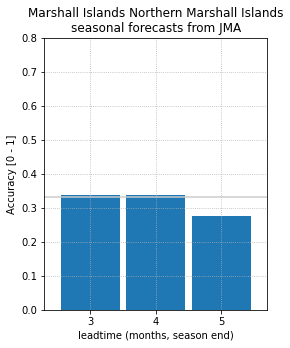

In [127]:
f = validation.plot(kind='bar', ylabel='Accuracy [0 - 1]', xlabel='leadtime (months, season end)', ylim=[None, 0.8], legend=None, figsize=(4,5), width=0.9) 
f.axes.set_title(f"{country} {admin}\n{period} forecasts from {GCM}")
f.axes.axhline(0.3333, color='0.8')
f.axes.grid(ls=':')
[l.set_rotation(0) for l in f.axes.xaxis.get_ticklabels()]
fig = plt.gcf()
fig.savefig(fig_path.joinpath(f'{utils.sanitize_name(country)}_{utils.sanitize_name(admin)}_{period}_{GCM}_{quantiles}_probs.png'), dpi=200, bbox_inches='tight', facecolor='w')